# Basic usage of scembed

scembed is meant to facilitate running distributed comaprisons of data integration approaches for single-cell and spatial data. As such, it's most powerful when combined with some library that takes care of scheduling jobs and tracking results, like [slurm-sweep](https://github.com/quadbio/slurm_sweep), which uses [weights and biases](https://wandb.ai/) in the backend. Thus, the best way to see scembed in action is to take a look at the [examples](https://github.com/quadbio/slurm_sweep/tree/main/examples) which are part of slurm-sweep package. 

Here, we'll just demonstrate the basic usage of a method wrapper combined with the evaluation class - it's much less exciting when run like this! 

## Preliminaries

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import scembed
import scanpy as sc
from scib_metrics.benchmark import BatchCorrection, BioConservation, Benchmarker

sc.set_figure_params(scanpy=True, frameon=False, fontsize=14)

Let's get some example data here. 

In [26]:
adata = sc.read("data/lung_atlas.h5ad", backup_url="https://figshare.com/ndownloader/files/24539942")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

Let's do simple processing

In [27]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, mask_var="highly_variable")

Let's define a few global parameter here. 

In [28]:
MODEL_PARAMS = {
    "batch_key": "batch",
    "cell_type_key": "cell_type",
    "pca_key": "X_pca",
    "unlabeled_category": "unknown",
}

EVAL_PARAMS = {
    "bio_conservation_metrics": BioConservation(),
    "batch_correction_metrics": BatchCorrection(pcr_comparison=False),
    "use_faiss": True,
}

PLOTTING_PARAMS = {"use_rapids": True, "additional_colors": ["location", "donor"], "ncols": 4, "wspace": 0.7}

## Apply integration approaches

We define a dict of methods here - not that we're using very few epochs for deep learing based methods here to speed things up. In reality, you should use more epochs. 

In [35]:
method_dict = {
    "harmony": scembed.methods.HarmonyMethod(adata, output_dir="results/harmony", **MODEL_PARAMS),
    "liger": scembed.methods.LIGERMethod(adata, output_dir="results/liger", **MODEL_PARAMS),
    "scanorama": scembed.methods.ScanoramaMethod(adata, output_dir="results/scanorama", **MODEL_PARAMS),
    "scvi": scembed.methods.scVIMethod(
        adata, n_layers=2, n_latent=30, max_epochs=20, output_dir="results/scvi", **MODEL_PARAMS
    ),
    "scanvi": scembed.methods.scANVIMethod(
        adata,
        n_samples_per_label=100,
        max_epochs=10,
        scvi_params={"max_epochs": 20},
        output_dir="results/scanvi",
        **MODEL_PARAMS,
    ),
    "scpoli": scembed.methods.scPoliMethod(
        adata, n_epochs=10, pretraining_epochs=9, output_dir="results/scpoli", **MODEL_PARAMS
    ),
    "hvg": scembed.methods.HVGMethod(adata, output_dir="results/hvg", **MODEL_PARAMS),
    "pca": scembed.methods.PrecomputedEmbeddingMethod(
        adata, embedding_key="X_pca", output_dir="results/pca", **MODEL_PARAMS
    ),
}

WARNING  Unlabeled category 'unknown' not found in cell type key 'cell_type'                                       
WARNING  Counts layer 'counts' contains non-integer values                                                         
INFO     Data validation passed for Harmony method.                                                                
INFO     Initialized Harmony method, saving outputs to 'results/harmony'.                                          
WARNING  Unlabeled category 'unknown' not found in cell type key 'cell_type'                                       
WARNING  Counts layer 'counts' contains non-integer values                                                         
INFO     Data validation passed for LIGER method.                                                                  
INFO     Initialized LIGER method, saving outputs to 'results/liger'.                                              
WARNING  Unlabeled category 'unknown' not found in cell type key 'cell_t

Use each method to compute a joint latent space. 

In [36]:
for key, method in method_dict.items():
    print(f"Working on {key}")
    method.fit()
    method.transform()

Working on harmony
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
Working on liger


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/pyliger/preprocessing/_scale.py:100: RuntimeWarning: divide by zero encountered in divide

100%|██████████| 30/30 [01:51<00:00,  3.73s/it]


Working on scanorama
Found 2000 genes among all datasets
[[0.   0.53 0.25 0.17 0.47 0.17 0.02 0.06 0.01 0.01 0.01 0.01 0.   0.01
  0.02 0.  ]
 [0.   0.   0.66 0.26 0.34 0.41 0.04 0.04 0.   0.02 0.02 0.01 0.01 0.02
  0.02 0.  ]
 [0.   0.   0.   0.35 0.79 0.61 0.02 0.03 0.03 0.02 0.03 0.01 0.01 0.
  0.   0.  ]
 [0.   0.   0.   0.   0.27 0.31 0.02 0.01 0.   0.01 0.04 0.01 0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.52 0.07 0.02 0.01 0.01 0.03 0.01 0.03 0.02
  0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.03 0.02 0.01 0.02 0.06 0.02 0.09 0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.79 0.65 0.56 0.21 0.57 0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.7  0.79 0.13 0.47 0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.54 0.04 0.53 0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.13 0.6  0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.23 0.01 0.01
  0.   0.  ]
 [0.   0.   0.   0.   

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

INFO     Set up scVI model:                                                                                        


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/s

Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 2/20:   5%|▌         | 1/20 [00:02<00:39,  2.09s/it, v_num=1, train_loss_step=547, train_loss_epoch=661]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 3/20:  10%|█         | 2/20 [00:04<00:37,  2.09s/it, v_num=1, train_loss_step=608, train_loss_epoch=593]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 4/20:  15%|█▌        | 3/20 [00:06<00:35,  2.08s/it, v_num=1, train_loss_step=623, train_loss_epoch=578]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 5/20:  20%|██        | 4/20 [00:08<00:33,  2.09s/it, v_num=1, train_loss_step=552, train_loss_epoch=568]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 6/20:  25%|██▌       | 5/20 [00:10<00:31,  2.09s/it, v_num=1, train_loss_step=504, train_loss_epoch=561]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 7/20:  30%|███       | 6/20 [00:12<00:29,  2.09s/it, v_num=1, train_loss_step=528, train_loss_epoch=555]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 8/20:  35%|███▌      | 7/20 [00:14<00:27,  2.10s/it, v_num=1, train_loss_step=543, train_loss_epoch=550]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 9/20:  40%|████      | 8/20 [00:16<00:25,  2.10s/it, v_num=1, train_loss_step=578, train_loss_epoch=546]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 10/20:  45%|████▌     | 9/20 [00:18<00:23,  2.10s/it, v_num=1, train_loss_step=519, train_loss_epoch=542]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 11/20:  50%|█████     | 10/20 [00:20<00:20,  2.09s/it, v_num=1, train_loss_step=495, train_loss_epoch=539]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 12/20:  55%|█████▌    | 11/20 [00:22<00:18,  2.08s/it, v_num=1, train_loss_step=560, train_loss_epoch=537]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 13/20:  60%|██████    | 12/20 [00:25<00:16,  2.08s/it, v_num=1, train_loss_step=517, train_loss_epoch=534]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 14/20:  65%|██████▌   | 13/20 [00:27<00:14,  2.09s/it, v_num=1, train_loss_step=479, train_loss_epoch=532]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 15/20:  70%|███████   | 14/20 [00:29<00:12,  2.09s/it, v_num=1, train_loss_step=549, train_loss_epoch=530]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 16/20:  75%|███████▌  | 15/20 [00:31<00:10,  2.08s/it, v_num=1, train_loss_step=545, train_loss_epoch=528]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 17/20:  80%|████████  | 16/20 [00:33<00:08,  2.09s/it, v_num=1, train_loss_step=471, train_loss_epoch=527]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 18/20:  85%|████████▌ | 17/20 [00:35<00:06,  2.09s/it, v_num=1, train_loss_step=498, train_loss_epoch=526]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 19/20:  90%|█████████ | 18/20 [00:37<00:04,  2.08s/it, v_num=1, train_loss_step=571, train_loss_epoch=524]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 20/20:  95%|█████████▌| 19/20 [00:39<00:02,  2.09s/it, v_num=1, train_loss_step=545, train_loss_epoch=523]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 20/20: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it, v_num=1, train_loss_step=537, train_loss_epoch=522]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it, v_num=1, train_loss_step=537, train_loss_epoch=522]
Working on scanvi
INFO     Training scVI model for scANVI pretraining                                                                
WARNING  Unlabeled category 'unknown' not found in cell type key 'cell_type'                                       
WARNING  Counts layer 'counts' contains non-integer values                                                         
INFO     Data validation passed for scVI method.                                                                   
INFO     Initialized scVI method, saving outputs to '/scratch/tmp.41108588.mlange/tmp31gwmcxi'.                    


/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

INFO     Set up scVI model:                                                                                        


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/s

Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 2/20:   5%|▌         | 1/20 [00:01<00:35,  1.88s/it, v_num=1, train_loss_step=577, train_loss_epoch=660]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 3/20:  10%|█         | 2/20 [00:03<00:33,  1.86s/it, v_num=1, train_loss_step=588, train_loss_epoch=593]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 4/20:  15%|█▌        | 3/20 [00:05<00:31,  1.85s/it, v_num=1, train_loss_step=608, train_loss_epoch=578]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 5/20:  20%|██        | 4/20 [00:07<00:29,  1.85s/it, v_num=1, train_loss_step=552, train_loss_epoch=568]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 6/20:  25%|██▌       | 5/20 [00:09<00:27,  1.87s/it, v_num=1, train_loss_step=583, train_loss_epoch=561]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 7/20:  30%|███       | 6/20 [00:11<00:26,  1.87s/it, v_num=1, train_loss_step=543, train_loss_epoch=556]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 8/20:  35%|███▌      | 7/20 [00:13<00:24,  1.90s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 9/20:  40%|████      | 8/20 [00:15<00:22,  1.88s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 10/20:  45%|████▌     | 9/20 [00:16<00:20,  1.88s/it, v_num=1, train_loss_step=473, train_loss_epoch=544]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 11/20:  50%|█████     | 10/20 [00:18<00:18,  1.89s/it, v_num=1, train_loss_step=515, train_loss_epoch=541]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 12/20:  55%|█████▌    | 11/20 [00:20<00:17,  1.89s/it, v_num=1, train_loss_step=519, train_loss_epoch=538]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 13/20:  60%|██████    | 12/20 [00:22<00:15,  1.89s/it, v_num=1, train_loss_step=550, train_loss_epoch=536]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 14/20:  65%|██████▌   | 13/20 [00:24<00:13,  1.87s/it, v_num=1, train_loss_step=560, train_loss_epoch=534]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 15/20:  70%|███████   | 14/20 [00:26<00:11,  1.87s/it, v_num=1, train_loss_step=522, train_loss_epoch=532]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 16/20:  75%|███████▌  | 15/20 [00:28<00:09,  1.86s/it, v_num=1, train_loss_step=509, train_loss_epoch=531]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 17/20:  80%|████████  | 16/20 [00:29<00:07,  1.87s/it, v_num=1, train_loss_step=633, train_loss_epoch=529]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 18/20:  85%|████████▌ | 17/20 [00:31<00:05,  1.85s/it, v_num=1, train_loss_step=506, train_loss_epoch=528]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 19/20:  90%|█████████ | 18/20 [00:33<00:03,  1.85s/it, v_num=1, train_loss_step=560, train_loss_epoch=527]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 20/20:  95%|█████████▌| 19/20 [00:35<00:01,  1.85s/it, v_num=1, train_loss_step=549, train_loss_epoch=526]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution


Epoch 20/20: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it, v_num=1, train_loss_step=549, train_loss_epoch=525]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it, v_num=1, train_loss_step=549, train_loss_epoch=525]
INFO     Creating scANVI from pretrained scVI model                                                                


/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?


ScanVI Model with the following params: 
unlabeled_category: unknown, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

INFO     Set up scANVI model:                                                                                      
INFO     Training scANVI model                                                                                     
INFO     Training for 10 epochs.                                                                                   


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/s

Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 2/10:  10%|█         | 1/10 [00:03<00:35,  3.98s/it, v_num=1, train_loss_step=522, train_loss_epoch=566]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 3/10:  20%|██        | 2/10 [00:07<00:31,  3.89s/it, v_num=1, train_loss_step=528, train_loss_epoch=530]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 4/10:  30%|███       | 3/10 [00:11<00:26,  3.86s/it, v_num=1, train_loss_step=513, train_loss_epoch=526]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 5/10:  40%|████      | 4/10 [00:15<00:23,  3.85s/it, v_num=1, train_loss_step=479, train_loss_epoch=524]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 6/10:  50%|█████     | 5/10 [00:19<00:19,  3.85s/it, v_num=1, train_loss_step=535, train_loss_epoch=523]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 7/10:  60%|██████    | 6/10 [00:23<00:15,  3.84s/it, v_num=1, train_loss_step=586, train_loss_epoch=522]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 8/10:  70%|███████   | 7/10 [00:26<00:11,  3.83s/it, v_num=1, train_loss_step=539, train_loss_epoch=521]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 9/10:  80%|████████  | 8/10 [00:30<00:07,  3.83s/it, v_num=1, train_loss_step=485, train_loss_epoch=520]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 10/10:  90%|█████████ | 9/10 [00:34<00:03,  3.83s/it, v_num=1, train_loss_step=564, train_loss_epoch=520]

/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/module/_scanvae.py:226: UserWarning: The value argument must be within the support of the distribution


Epoch 10/10: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it, v_num=1, train_loss_step=503, train_loss_epoch=519]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it, v_num=1, train_loss_step=503, train_loss_epoch=519]
Working on scpoli


/cluster/project/treutlein/USERS/mlange/github/scarches/scarches/models/scpoli/scpoli_model.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/cluster/project/treutlein/USERS/mlange/github/scarches/scarches/models/scpoli/scpoli_model.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/cluster/project/treutlein/USERS/mlange/github/scarches/scarches/models/scpoli/scpoli_model.py:164: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

Embedding dictionary:
 	Num conditions: [16]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 2000 45 10
	Mean/Var Layer in/out: 45 10
Decoder Architecture:
	First Layer in, out and cond:  10 45 10
	Output Layer in/out:  45 2000 

Initializing dataloaders
Starting training
 |██████████████████--| 90.0%  - val_loss:  577.27 - val_cvae_loss:  577.27
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Epoch 68/246:  27%|██▋       | 67/246 [11:33<30:52, 10.35s/it, v_num=1, train_loss_step=469, train_loss_epoch=513]


/cluster/project/treutlein/USERS/mlange/github/scarches/scarches/trainers/scpoli/trainer.py:510: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


Clustering succesful. Found 29 clusters.
 |████████████████████| 100.0%  - val_loss:  585.27 - val_cvae_loss:  576.13 - val_prototype_loss:    9.14 - val_unlabeled_loss:    0.81 - val_labeled_loss:    9.14
Working on hvg
INFO     This selected 1586 highly variable genes.                                                                 
Working on pca


## Evaluate integration approaches

scembed is designed to evaluate integration approaches one by one, as in a typical distributed setup where each job fits a single method, evaluates intefration performance, and logs the results somewhere. This is of course a bit inconvenien here, we we would ideally like to show all methods jointly. In toy scenarios like this one, where we run all method together in one notebook, it's much easier to use scIB metrics directly based on a single AnnData object that contains all embeddings in `.obsm`. 

Thus, we'll simply aggregate all data into one AnnData object and use scIB directly here. 

In [42]:
embedding_keys = []

for key, method in method_dict.items():
    adata.obsm[f"X_{key}"] = method.adata.obsm[method.embedding_key].copy()
    embedding_keys.append(method.embedding_key)

In [46]:
bm = Benchmarker(
    adata,
    batch_key=MODEL_PARAMS["batch_key"],
    label_key=MODEL_PARAMS["cell_type_key"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=embedding_keys,
    pre_integrated_embedding_obsm_key=MODEL_PARAMS["pca_key"],
    n_jobs=6,
)
bm.benchmark()

Metrics:  70%|███████   | 7/10 [00:13<00:07,  2.62s/it, Batch correction: graph_connectivity]/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  12%|█▎        | 1/8 [00:14<01:41, 14.56s/it]atch correction: pcr_comparison]
                                                                                         
Metrics:  70%|███████   | 7/10 [00:15<00:09,  3.11s/it, Batch correction: graph_connectivity]/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  25%|██▌       | 2/8 [00:30<01:31, 15.29s/it]atch correction: pcr_compar

Let's take a look at what we got. 

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate s

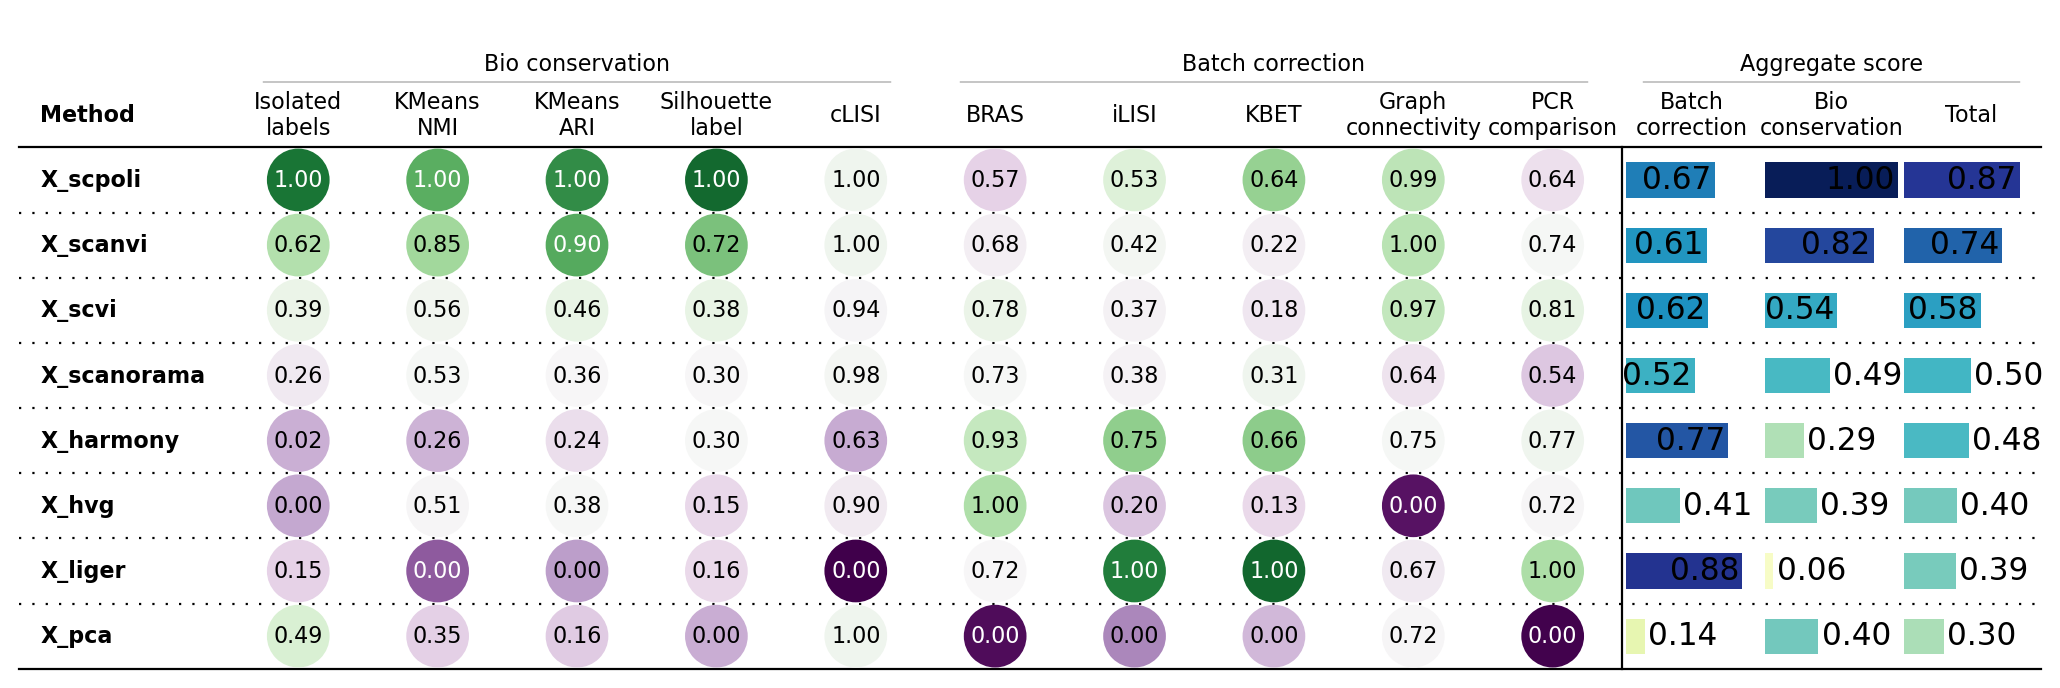

In [48]:
bm.plot_results_table(min_max_scale=True)

Again, to make use of the real power of scembed, you need to run this in a distributed fashion, take a look at the [slurm-sweep](https://github.com/quadbio/slurm_sweep) package. 